<a href="https://colab.research.google.com/github/sarcasticvibes/Face-Mask-Detection-via-Detectron2/blob/master/Face_Mask_Detection_via_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sarcasticvibes","key":"41883d4fbccff1f3662a136f9c271ee4"}'}

In [0]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d wobotintelligence/face-mask-detection-dataset

100% 2.49G/2.50G [00:36<00:00, 23.8MB/s]
100% 2.50G/2.50G [00:36<00:00, 73.1MB/s]


In [0]:
! unzip face-mask-detection-dataset.zip

In [6]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 4.5MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=0b84959d067648cdb8248a01c0d7d323de1dd7378f5caacebc8814666e867ed2
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-7p312qdj
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-7p312qdj
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-lin

In [7]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 1.9MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200614-cp36-none-any.whl size=41031 sha256=05d12e33bb775328333b1681a8915b5153fbbd043b53d43fff5d88cd1e868ce7
  Stored in directory: /root/.cache/pip/wheels/85/83/90/8d8b68a2b79df3bbd34a9981742deacce1fcd7e3a1484ff2b5
Successfully built fvcore


In [8]:
import torch
torch.cuda.get_device_name()

'Tesla P100-PCIE-16GB'

In [0]:
import os
import pandas as pd
import torch.nn as nn
from PIL import Image
import numpy as np
import torch.nn.functional as F
from torch.optim import lr_scheduler

from sklearn import model_selection
from sklearn import metrics
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split
import random
import cv2
from google.colab.patches import cv2_imshow

In [0]:
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

In [0]:
df = pd.read_csv('/content/train.csv')

In [5]:
df

name   x1   x2   y1   y2       classname
0      2756.png   69  126  294  392  face_with_mask
1      2756.png  505   10  723  283  face_with_mask
2      2756.png   75  252  264  390   mask_colorful
3      2756.png  521  136  711  277   mask_colorful
4      6098.jpg  360   85  728  653    face_no_mask
...         ...  ...  ...  ...  ...             ...
15407  1894.jpg  437  121  907  644  face_with_mask
15408  1894.jpg  557  363  876  636   mask_surgical
15409  1894.jpg  411    3  940  325             hat
15410  3216.png  126   69  409  463  face_with_mask
15411  3216.png  136  289  393  461   mask_colorful

[15412 rows x 6 columns]

In [0]:
img_folder_dir = '/content/Medical mask/Medical mask/Medical Mask/images'

In [0]:
! mkdir /content/image_pickles

In [20]:
import joblib
for image in tqdm(os.listdir(img_folder_dir), total=len(os.listdir(img_folder_dir))):
  im = np.array(Image.open(f'{img_folder_dir}/{image}'))
  image_id = image[:-4] if '.jpeg' not in image else image[:-5]
  assert int(image_id)
  joblib.dump(im, f"/content/image_pickles/{image_id}.pkl")

In [0]:
categories = {j:i for i, j in enumerate(df.classname.unique())}

In [14]:
categories

{'balaclava_ski_mask': 18,
 'eyeglasses': 7,
 'face_no_mask': 2,
 'face_other_covering': 5,
 'face_shield': 9,
 'face_with_mask': 0,
 'face_with_mask_incorrect': 3,
 'gas_mask': 17,
 'goggles': 13,
 'hair_net': 14,
 'hat': 12,
 'helmet': 8,
 'hijab_niqab': 15,
 'hood': 11,
 'mask_colorful': 1,
 'mask_surgical': 4,
 'other': 16,
 'scarf_bandana': 6,
 'sunglasses': 10,
 'turban': 19}

In [0]:
def get_train_dataset():
  train_data = []
  for img in df.name.unique():
    record = {}
    image_id = img[:-4] if '.jpeg' not in img else img[:-5]
    height, width, _ = np.array(Image.open(f'{img_folder_dir}/{img}')).shape
    record['file_name'] = f'{img_folder_dir}/{img}'
    record["image_id"] = image_id
    record["height"] = height
    record["width"] = width

    objs = []
    d = df[df['name'] == img]
    for _, row in d.iterrows():

      xmin = min(row.x1, row.y1)
      ymin = min(row.x2, row.y2)
      xmax = max(row.x1, row.y1)
      ymax = max(row.x2, row.y2)

      poly = [
          (xmin, ymin), (xmax, ymin), 
          (xmax, ymax), (xmin, ymax)
      ]
      poly = [p for x in poly for p in x]

      obj = {
        "bbox": [xmin, ymin, xmax, ymax],
        "bbox_mode": BoxMode.XYXY_ABS,
        "segmentation": [poly],
        "category_id": categories[row.classname],
        "iscrowd": 0
      }
      objs.append(obj)
    record["annotations"] = objs
    train_data.append(record)
  return train_data

In [0]:
def get_test_dataset():
  d = pd.read_csv('/content/submission.csv')
  test_data = []
  for img in d.name.unique():
    record = {}
    image_id = img[:-4] if '.jpeg' not in img else img[:-5]
    if ('jpe' in img and 'jpeg' not in img):
      img = (img + 'g') 
    height, width, _ = np.array(Image.open(f'{img_folder_dir}/{img}')).shape
    record['file_name'] = f'{img_folder_dir}/{img}'
    record["image_id"] = image_id
    record["height"] = height
    record["width"] = width
    record["annotations"] = None
    test_data.append(record)
  return test_data

In [0]:
dataset_dicts = get_train_dataset()

In [0]:
d="train"
DatasetCatalog.register("Face_Mask_Detection_TrainingSet", lambda d=d: get_train_dataset())
MetadataCatalog.get("Face_Mask_Detection_TrainingSet").set(thing_classes=[class_ for class_ in df.classname.unique()])
face_metadata = MetadataCatalog.get("Face_Mask_Detection_TrainingSet")

In [0]:
d="test"
DatasetCatalog.register("Face_Mask_Detection_TestSet", lambda d=d: get_test_dataset())
MetadataCatalog.get("Face_Mask_Detection_TestSet").set(thing_classes=[class_ for class_ in df.classname.unique()])
face_metadata = MetadataCatalog.get("Face_Mask_Detection_TestSet")

(1346, 2020, 3)
[{'bbox': [601, 11, 1461, 1142], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[601, 11, 1461, 11, 1461, 1142, 601, 1142]], 'category_id': 5, 'iscrowd': 0}, {'bbox': [663, 376, 1424, 1130], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[663, 376, 1424, 376, 1424, 1130, 663, 1130]], 'category_id': 6, 'iscrowd': 0}]


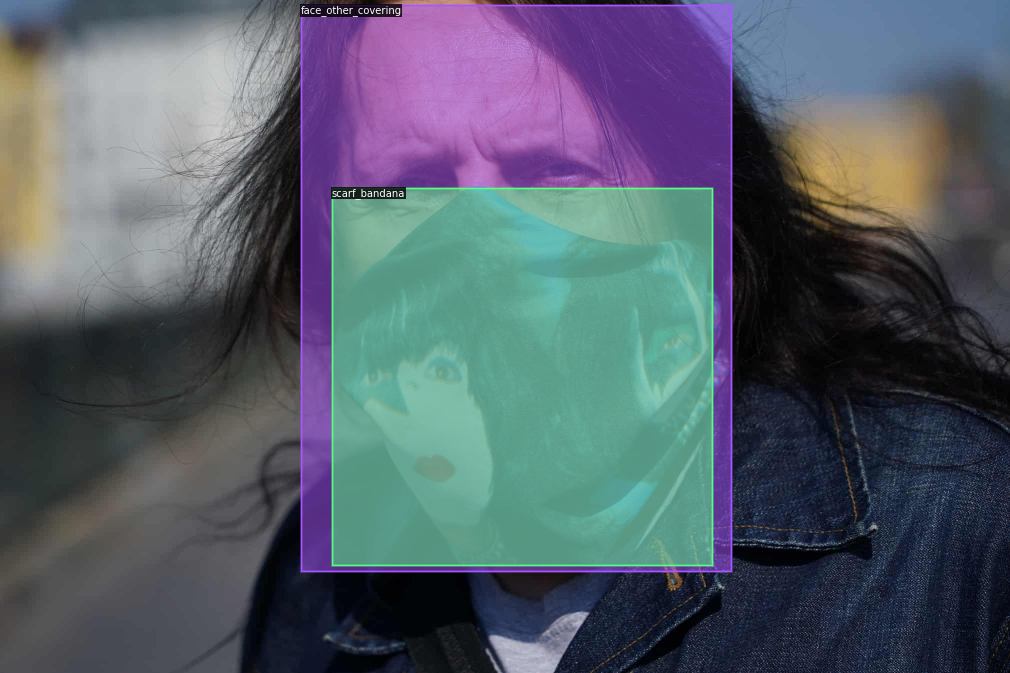

(533, 728, 3)
[{'bbox': [79, 56, 465, 355], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[79, 56, 465, 56, 465, 355, 79, 355]], 'category_id': 0, 'iscrowd': 0}, {'bbox': [252, 108, 462, 348], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[252, 108, 462, 108, 462, 348, 252, 348]], 'category_id': 1, 'iscrowd': 0}]


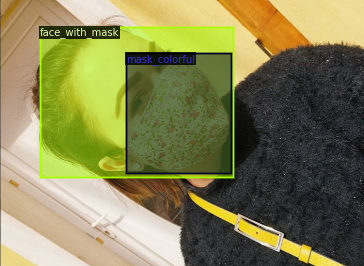

(800, 1200, 3)
[{'bbox': [251, 135, 730, 667], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[251, 135, 730, 135, 730, 667, 251, 667]], 'category_id': 0, 'iscrowd': 0}, {'bbox': [318, 358, 722, 660], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[318, 358, 722, 358, 722, 660, 318, 660]], 'category_id': 4, 'iscrowd': 0}]


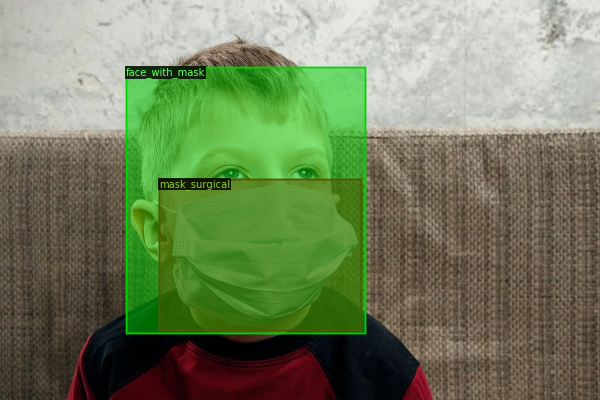

In [29]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=face_metadata, scale = .5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

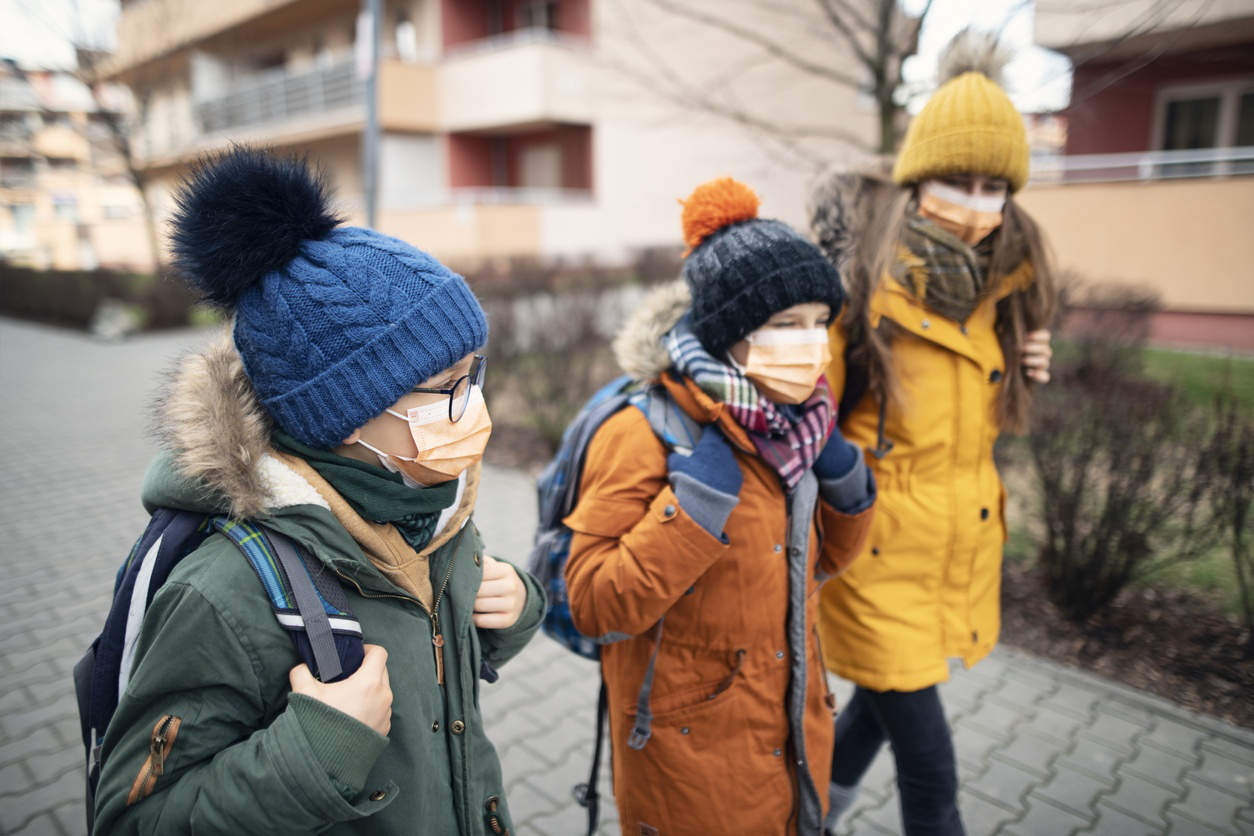

In [21]:
Image.open(f'{img_folder_dir}/1799.jpg')

In [18]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("Face_Mask_Detection_TrainingSet",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 5
cfg.SOLVER.BASE_LR = 0.0002  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 20  # only has one class (text)
cfg.OUTPUT_DIR = f'/content/drive/My Drive/Face_Mask_Detection_via_Detectron2outputs/RCNNx101'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/14 20:44:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_2d9806.pkl: 431MB [00:06, 67.2MB/s]                           
Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (21, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (21,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (80, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (80,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (20, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (20,) in the model!


[06/14 20:46:37 d2.engine.train_loop]: Starting training from iteration 0
[06/14 20:47:23 d2.utils.events]:  eta: 3:09:36  iter: 19  total_loss: 4.454  loss_cls: 3.246  loss_box_reg: 0.266  loss_mask: 0.691  loss_rpn_cls: 0.168  loss_rpn_loc: 0.029  time: 2.2624  data_time: 0.1364  lr: 0.000004  max_mem: 13790M
[06/14 20:48:08 d2.utils.events]:  eta: 3:08:50  iter: 39  total_loss: 4.382  loss_cls: 3.119  loss_box_reg: 0.357  loss_mask: 0.689  loss_rpn_cls: 0.178  loss_rpn_loc: 0.028  time: 2.2358  data_time: 0.1701  lr: 0.000008  max_mem: 13790M
[06/14 20:48:52 d2.utils.events]:  eta: 3:05:47  iter: 59  total_loss: 4.031  loss_cls: 2.846  loss_box_reg: 0.348  loss_mask: 0.683  loss_rpn_cls: 0.150  loss_rpn_loc: 0.029  time: 2.2338  data_time: 0.1060  lr: 0.000012  max_mem: 13790M
[06/14 20:49:37 d2.utils.events]:  eta: 3:05:02  iter: 79  total_loss: 3.724  loss_cls: 2.511  loss_box_reg: 0.312  loss_mask: 0.677  loss_rpn_cls: 0.148  loss_rpn_loc: 0.027  time: 2.2412  data_time: 0.0766  

In [44]:
# Look at training curves in tensorboard:
! kill 5487
%load_ext tensorboard
%tensorboard --logdir content/drive/My Drive/Face_Mask_Detection_via_Detectron2outputs/events.out.tfevents.1592080678.1e504b5410bf.121.2

/bin/bash: line 0: kill: (5487) - No such process
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2020-06-14 01:32:46.646358: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--purge_orphaned_data BOOL] [--db URI] [--db_import]
                   [--inspect] [--version_tb] [--tag TAG] [--event_file PATH]
                   [--path_prefix PATH] [--window_title TEXT]
                   [--max_reload_threads COUNT] [--reload_interval SECONDS]
                   [--reload_task TYPE] [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--debugger_data_server_grpc_port PORT]
                   [--debugger_port PORT]
                   {se

In [0]:
cfg.MODEL.WEIGHTS = '/content/drive/My Drive/Face_Mask_Detection_via_Detectron2outputs/RCNNx101/model_final.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("Face_Mask_Detection_TestSet", )
predictor = DefaultPredictor(cfg)

In [0]:
test_dataset_dicts = get_test_dataset()

Instances(num_instances=1, image_height=1024, image_width=683, fields=[pred_boxes: Boxes(tensor([[157.3306,  84.1197, 538.0109, 554.4398]], device='cuda:0')), scores: tensor([0.9892], device='cuda:0'), pred_classes: tensor([2], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])


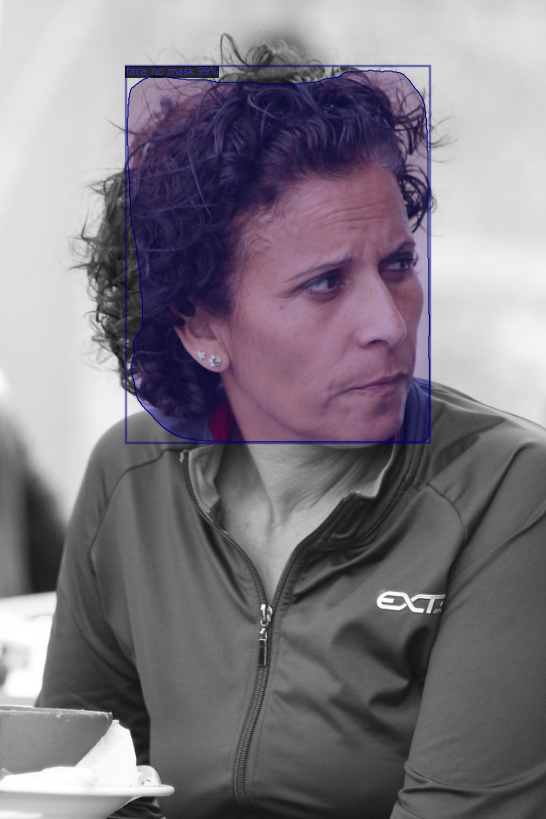

Instances(num_instances=5, image_height=900, image_width=1200, fields=[pred_boxes: Boxes(tensor([[ 679.3210,  248.6488, 1076.4178,  794.1247],
        [ 164.6626,  120.7421,  500.0679,  580.3077],
        [ 191.4889,  320.2112,  491.2483,  571.3416],
        [ 719.9690,  412.7778, 1031.9127,  527.7072],
        [ 719.3052,  486.6948, 1073.1014,  781.2960]], device='cuda:0')), scores: tensor([0.9934, 0.9920, 0.9898, 0.9732, 0.9632], device='cuda:0'), pred_classes: tensor([0, 0, 1, 7, 1], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False

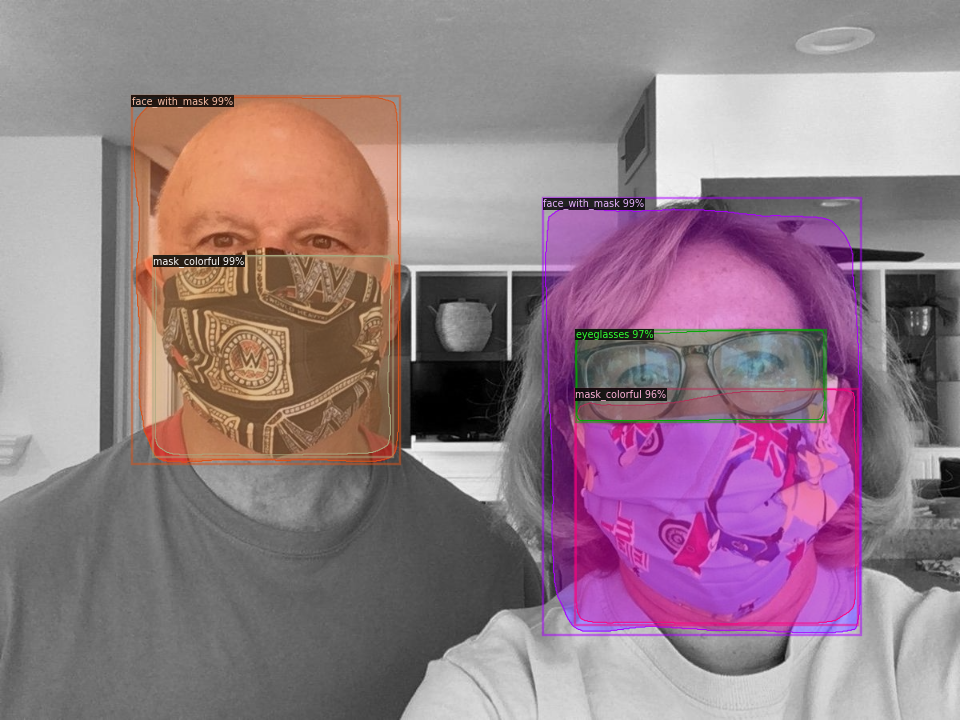

Instances(num_instances=2, image_height=685, image_width=1024, fields=[pred_boxes: Boxes(tensor([[351.0511,  72.5926, 633.2047, 504.3077],
        [366.2021, 298.2254, 631.6425, 498.7482]], device='cuda:0')), scores: tensor([0.9964, 0.8237], device='cuda:0'), pred_classes: tensor([0, 1], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
  

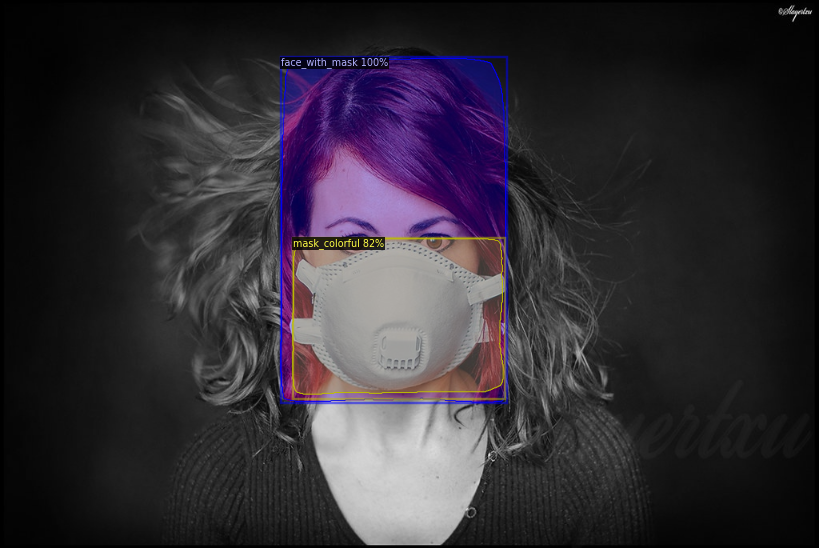

Instances(num_instances=7, image_height=603, image_width=1024, fields=[pred_boxes: Boxes(tensor([[528.8984,  23.3637, 755.5685, 285.5876],
        [309.8756,  39.5880, 479.2240, 261.5643],
        [314.0378, 144.8785, 437.2357, 259.8939],
        [540.5170, 140.0997, 673.2686, 277.7568],
        [524.9593, 105.4703, 646.5173, 166.0153],
        [771.1841,  93.6836, 897.0295, 235.1837],
        [169.5374, 128.6074, 197.9496, 157.1599]], device='cuda:0')), scores: tensor([0.9860, 0.9856, 0.9771, 0.9705, 0.9665, 0.8917, 0.7210],
       device='cuda:0'), pred_classes: tensor([0, 0, 4, 4, 7, 2, 7], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],


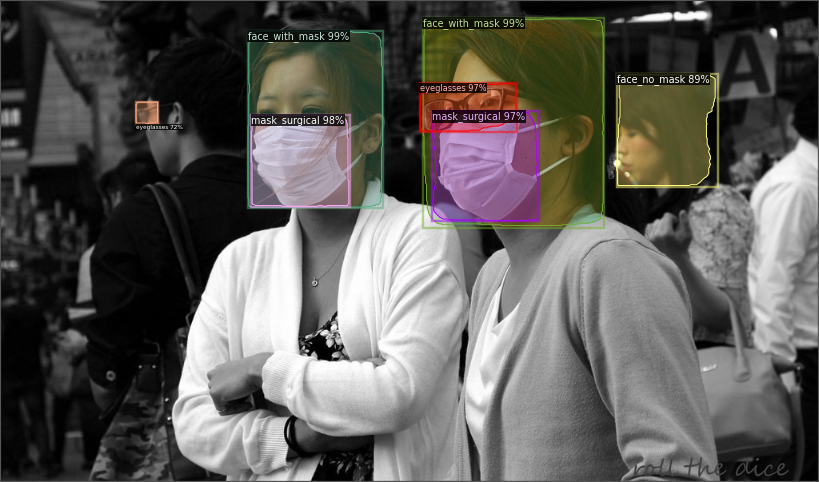

Instances(num_instances=2, image_height=1024, image_width=819, fields=[pred_boxes: Boxes(tensor([[466.7949, 310.0795, 557.2755, 417.4337],
        [471.4153, 368.3334, 531.1583, 412.5607]], device='cuda:0')), scores: tensor([0.9320, 0.7072], device='cuda:0'), pred_classes: tensor([0, 1], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
  

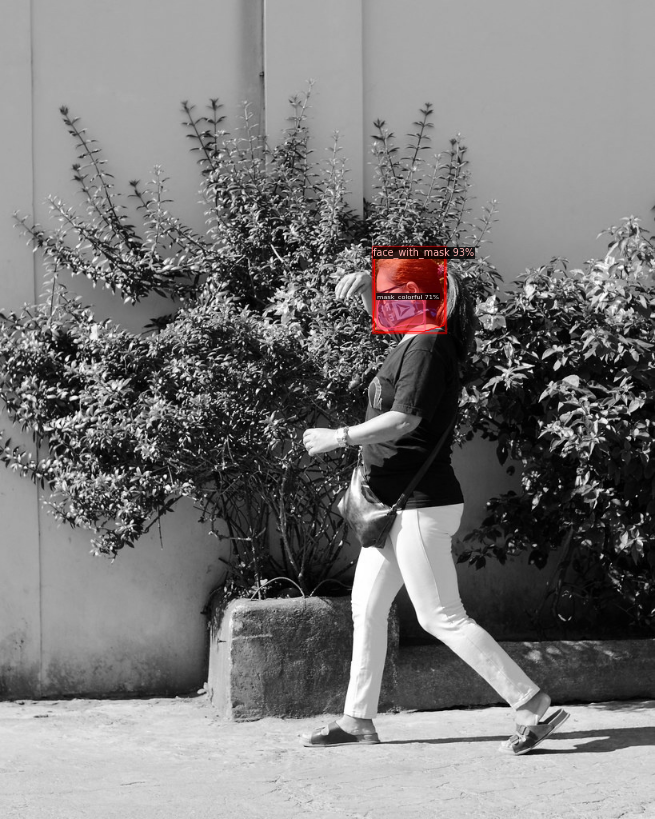

In [23]:
from detectron2.utils.visualizer import ColorMode
for d in random.sample(test_dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs['instances'])
    v = Visualizer(im[:, :, ::-1],
                   metadata=face_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])